# Prompt Optimization Mini Project Result Visualizations

This notebook visualizes the results from the three implemented prompt optimization algorithms (in typescript):
- **APE**: Automatic Prompt Engineering (paraphrasing)
  In which candidate prompts are paraphrased N times from a base prompt using different mutators and evaluated over
- **Evolution**: Binary Tournament Genetic Algorithm
  In which the pool of candidate prompts is generated using different mutators and in a tournament the winning prompt is mutated and replaces the losing prompt
- **Thompson Sampling**: NIG Multi-Armed Bandit
  In which candidates are randomly sampled from a distribution of unknown variance and unknown mean, here the candidates are pulled one at a time and evaluaed, the evaluation updates the posteriors


Dataset benchmarks used: PIQA, HellaSwag, BoolQ, GSM8K

In [ ]:
%pip install matplotlib

In [54]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load Results

In [55]:
def load_results(dataset_name):
    try:
        with open(f'results_{dataset_name}.json', 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: results_{dataset_name}.json not found")
        return None

# Load all datasets
datasets = ['piqa', 'hellaswag', 'boolq', 'gsm8k']
results = {}

for dataset in datasets:
    data = load_results(dataset)
    if data:
        results[dataset] = data
        print(f"Loaded {dataset}: {data['numExamples']} examples")

print(f"\nLoaded {len(results)} datasets")

Loaded piqa: 30 examples
Loaded hellaswag: 30 examples
Loaded boolq: 30 examples
Loaded gsm8k: 20 examples

Loaded 4 datasets


In [56]:
def extract_history(algorithm_data):
    history = algorithm_data.get('bestPrompts', [])
    if not history:
        return [], []

    tokens = [h['tokens'] for h in history]
    scores = [h['score'] for h in history]
    return tokens, scores

def calculate_efficiency(tokens, score):
    return (score / tokens * 1000) if tokens > 0 else 0

## Dataset Plots

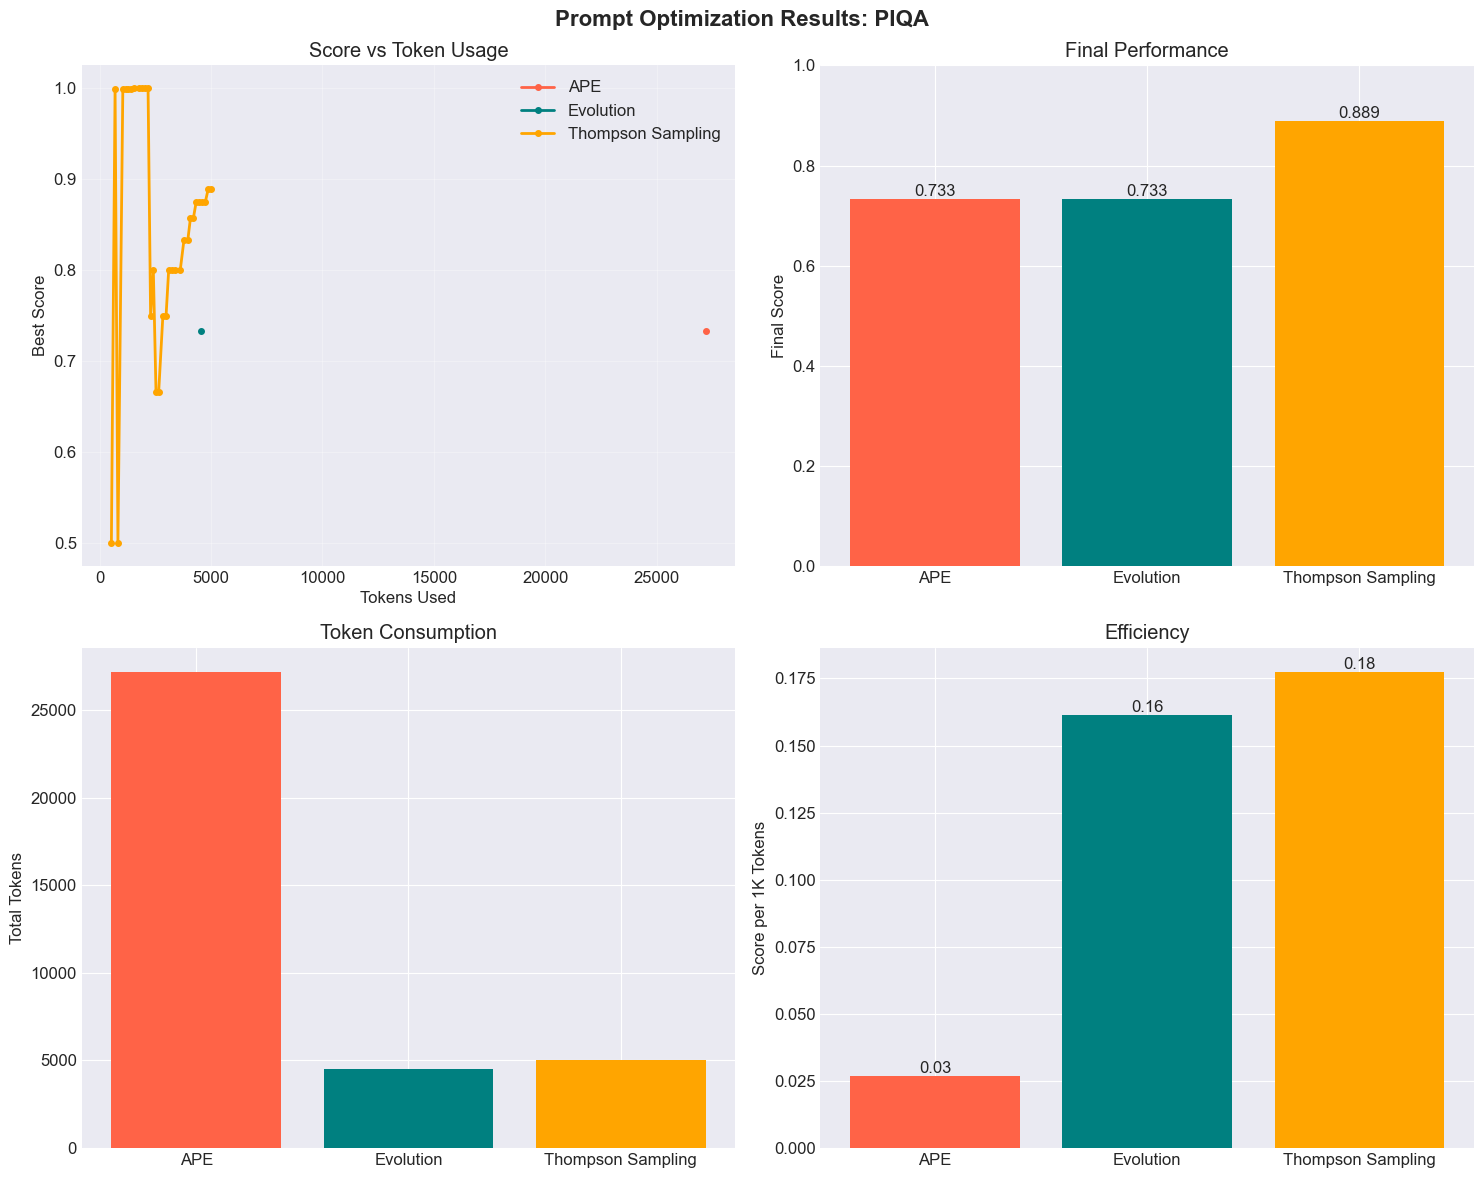

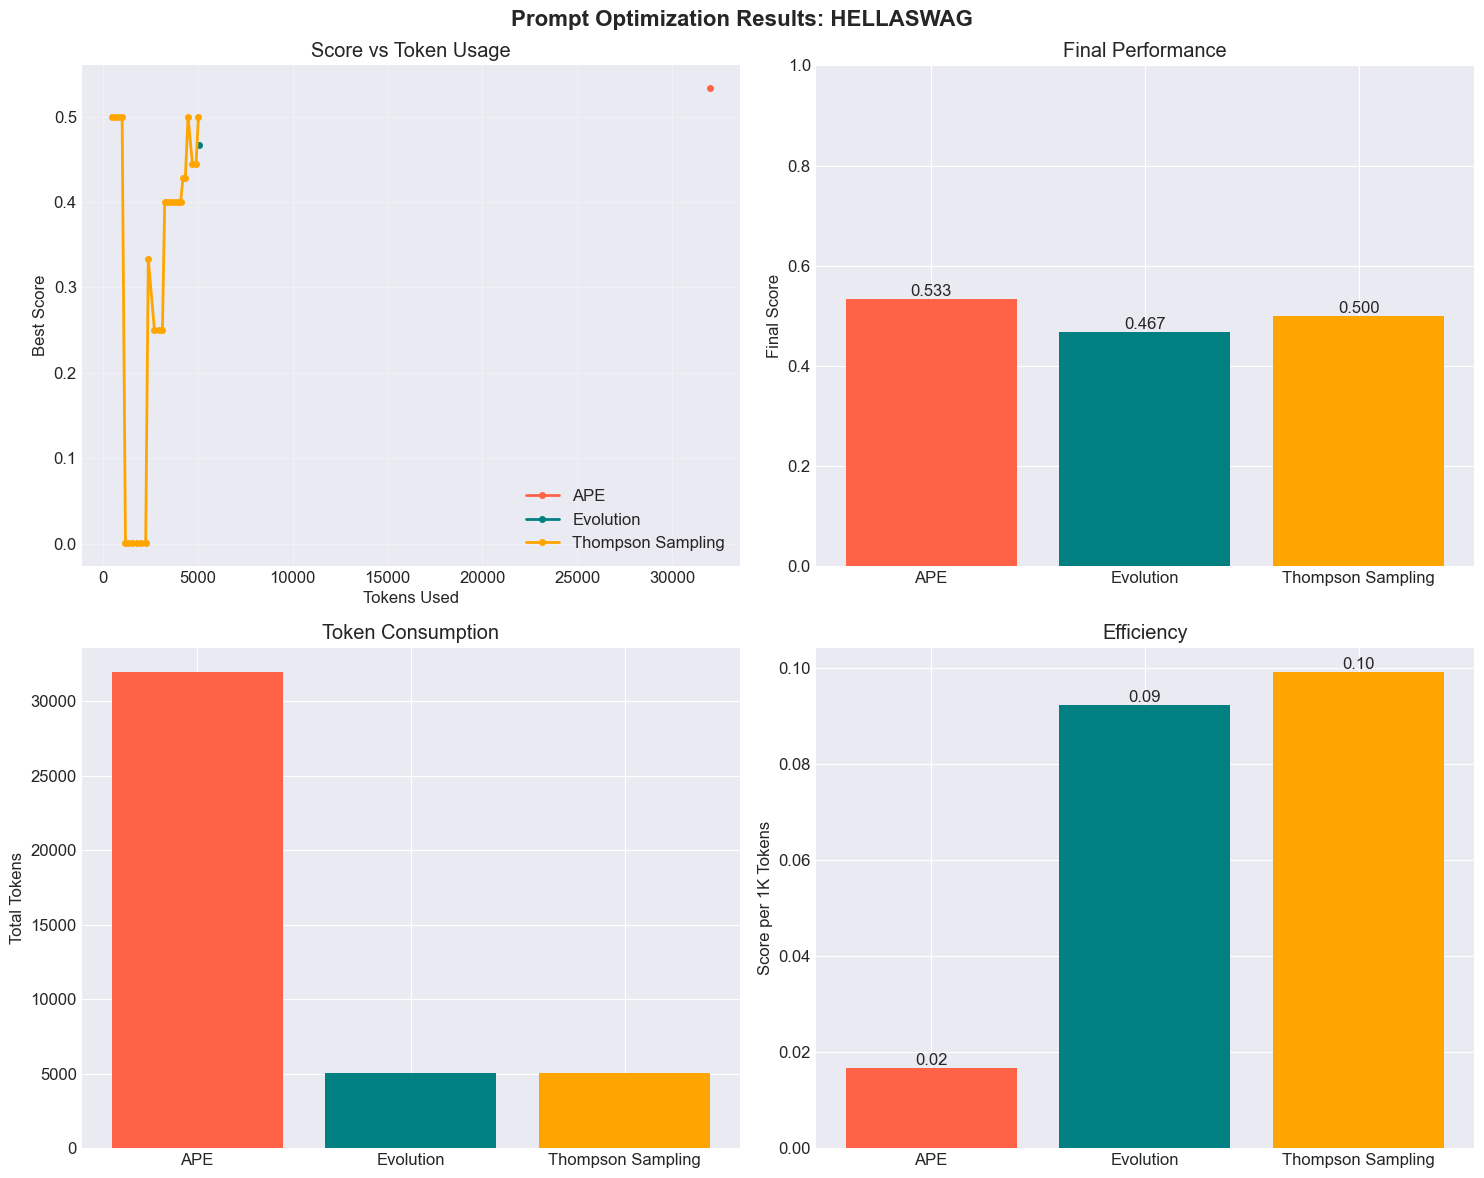

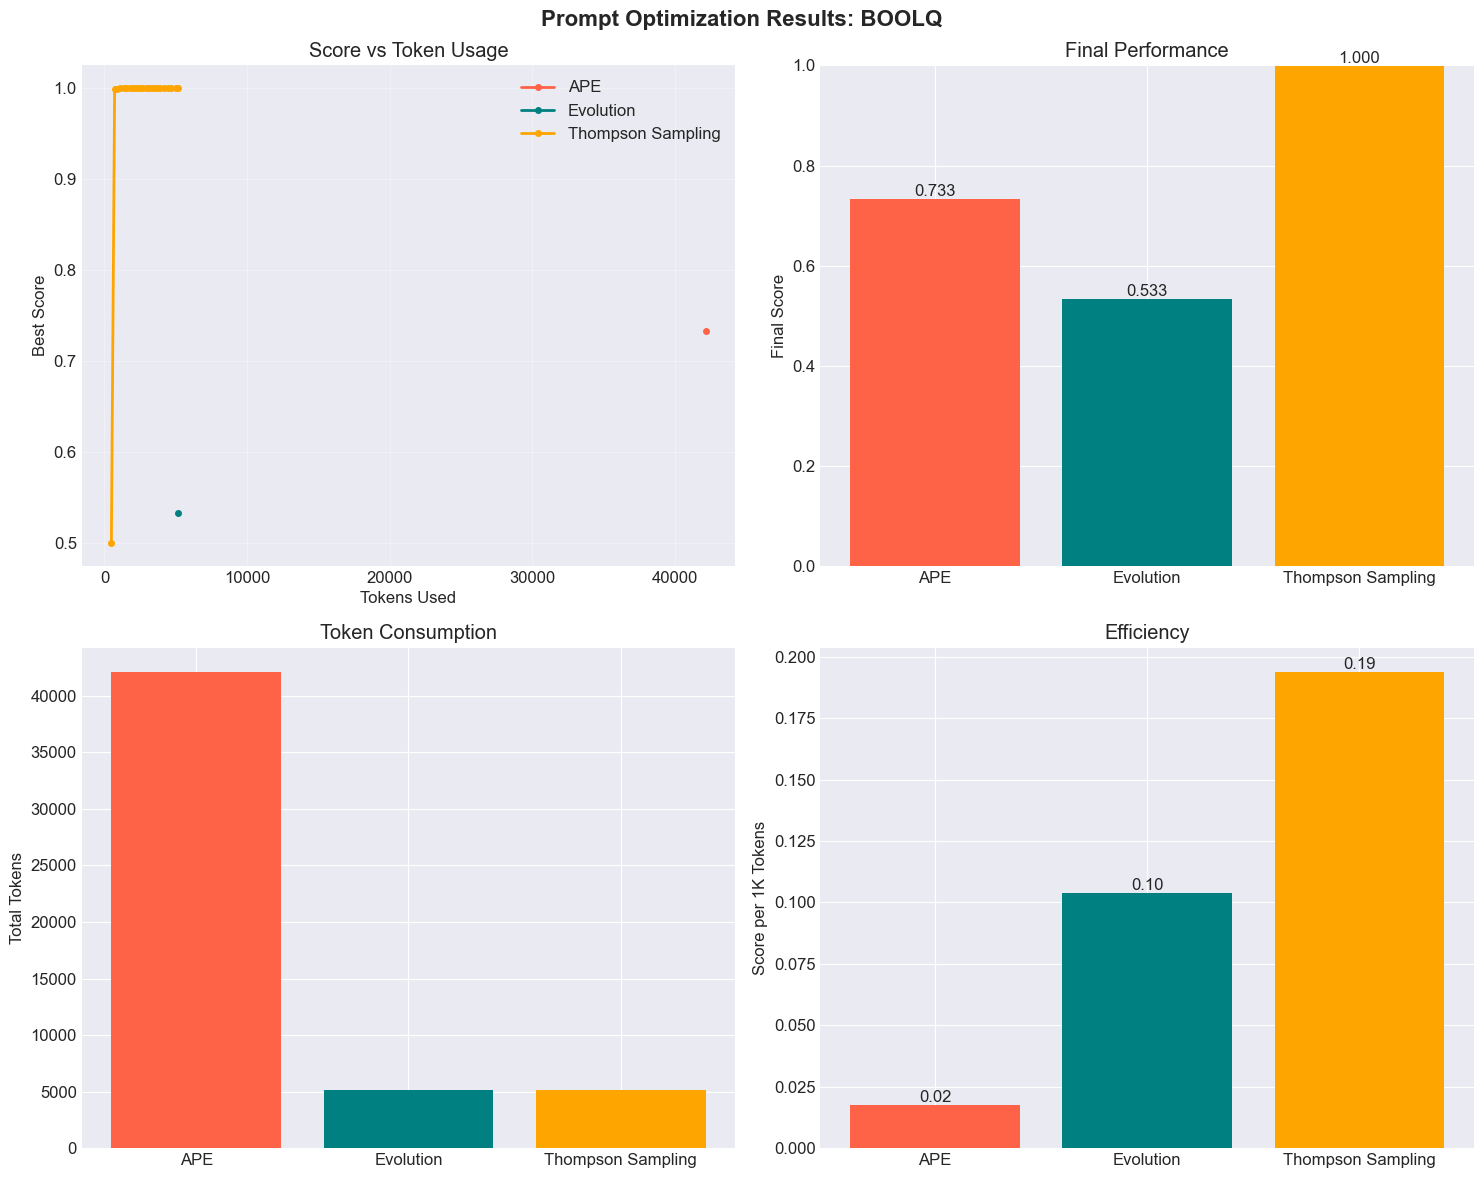

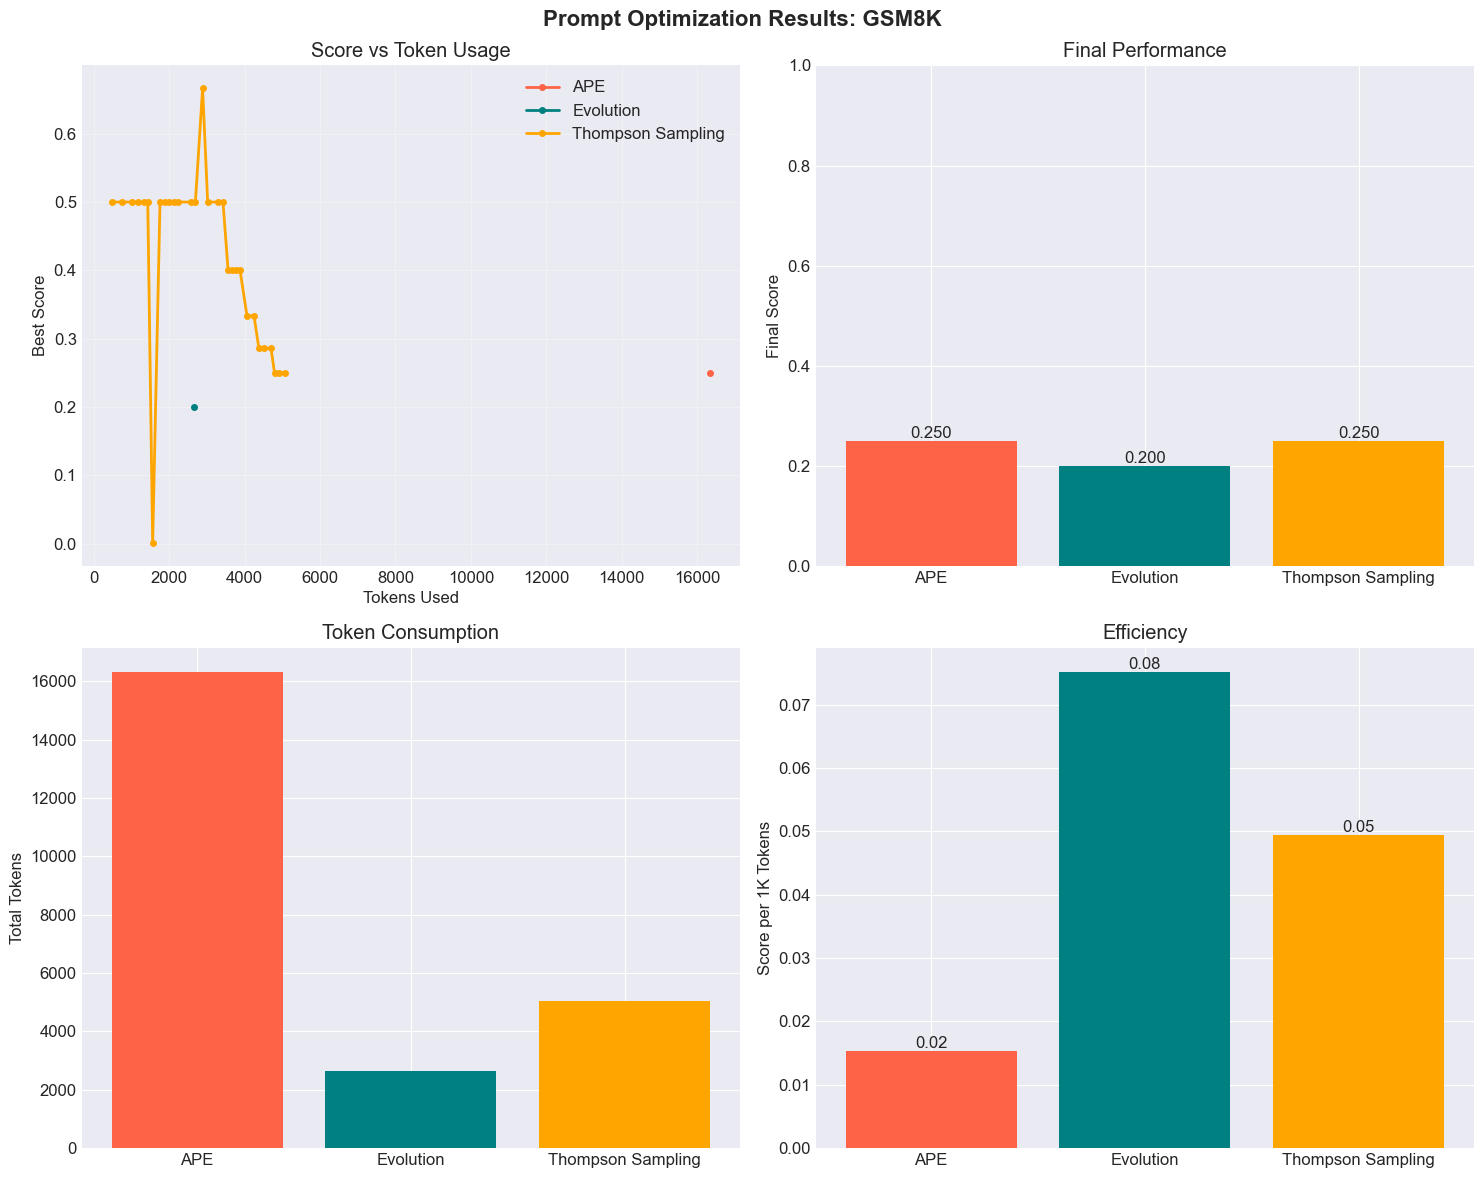

In [57]:
def plot_dataset_comparison(dataset_name, data):
    """Create comparison plot for a single dataset"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Prompt Optimization Results: {dataset_name.upper()}',
                 fontsize=16, fontweight='bold')

    # Extract data for each algorithm
    algorithms = ['ape', 'evo', 'ts']
    colors = {'ape': 'tomato', 'evo': 'teal', 'ts': 'orange'}
    labels = {'ape': 'APE', 'evo': 'Evolution', 'ts': 'Thompson Sampling'}

    histories = {}
    for alg in algorithms:
        if alg in data:
            tokens, scores = extract_history(data[alg])
            histories[alg] = {'tokens': tokens, 'scores': scores}

    # Score vs Tokens
    ax1 = axes[0, 0]
    for alg in algorithms:
        if alg in histories:
            h = histories[alg]
            ax1.plot(h['tokens'], h['scores'],
                    marker='o', label=labels[alg],
                    color=colors[alg], linewidth=2, markersize=4)

    ax1.set_xlabel('Tokens Used')
    ax1.set_ylabel('Best Score')
    ax1.set_title('Score vs Token Usage')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Final scores bar chart
    ax2 = axes[0, 1]
    final_scores = {}
    for alg in algorithms:
        if alg in histories and histories[alg]['scores']:
            final_scores[labels[alg]] = histories[alg]['scores'][-1]

    bars = ax2.bar(final_scores.keys(), final_scores.values(),
                   color=[colors[alg] for alg in algorithms if alg in histories])
    ax2.set_ylabel('Final Score')
    ax2.set_title('Final Performance')
    ax2.set_ylim(0, 1)

    # Value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Token usage
    ax3 = axes[1, 0]
    token_usage = {}
    for alg in algorithms:
        if alg in histories and histories[alg]['tokens']:
            token_usage[labels[alg]] = histories[alg]['tokens'][-1]

    ax3.bar(token_usage.keys(), token_usage.values(),
           color=[colors[alg] for alg in algorithms if alg in histories])
    ax3.set_ylabel('Total Tokens')
    ax3.set_title('Token Consumption')

    # Efficiency (score per 1k tokens)
    ax4 = axes[1, 1]
    efficiency = {}
    for alg in algorithms:
        if alg in histories and histories[alg]['scores'] and histories[alg]['tokens']:
            score = histories[alg]['scores'][-1]
            tokens = histories[alg]['tokens'][-1]
            efficiency[labels[alg]] = calculate_efficiency(tokens, score)

    bars = ax4.bar(efficiency.keys(), efficiency.values(),
                   color=[colors[alg] for alg in algorithms if alg in histories])
    ax4.set_ylabel('Score per 1K Tokens')
    ax4.set_title('Efficiency')

    # Value labels
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'plots_{dataset_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

for dataset_name, data in results.items():
    plot_dataset_comparison(dataset_name, data)

## 4. Cross-Dataset Comparison

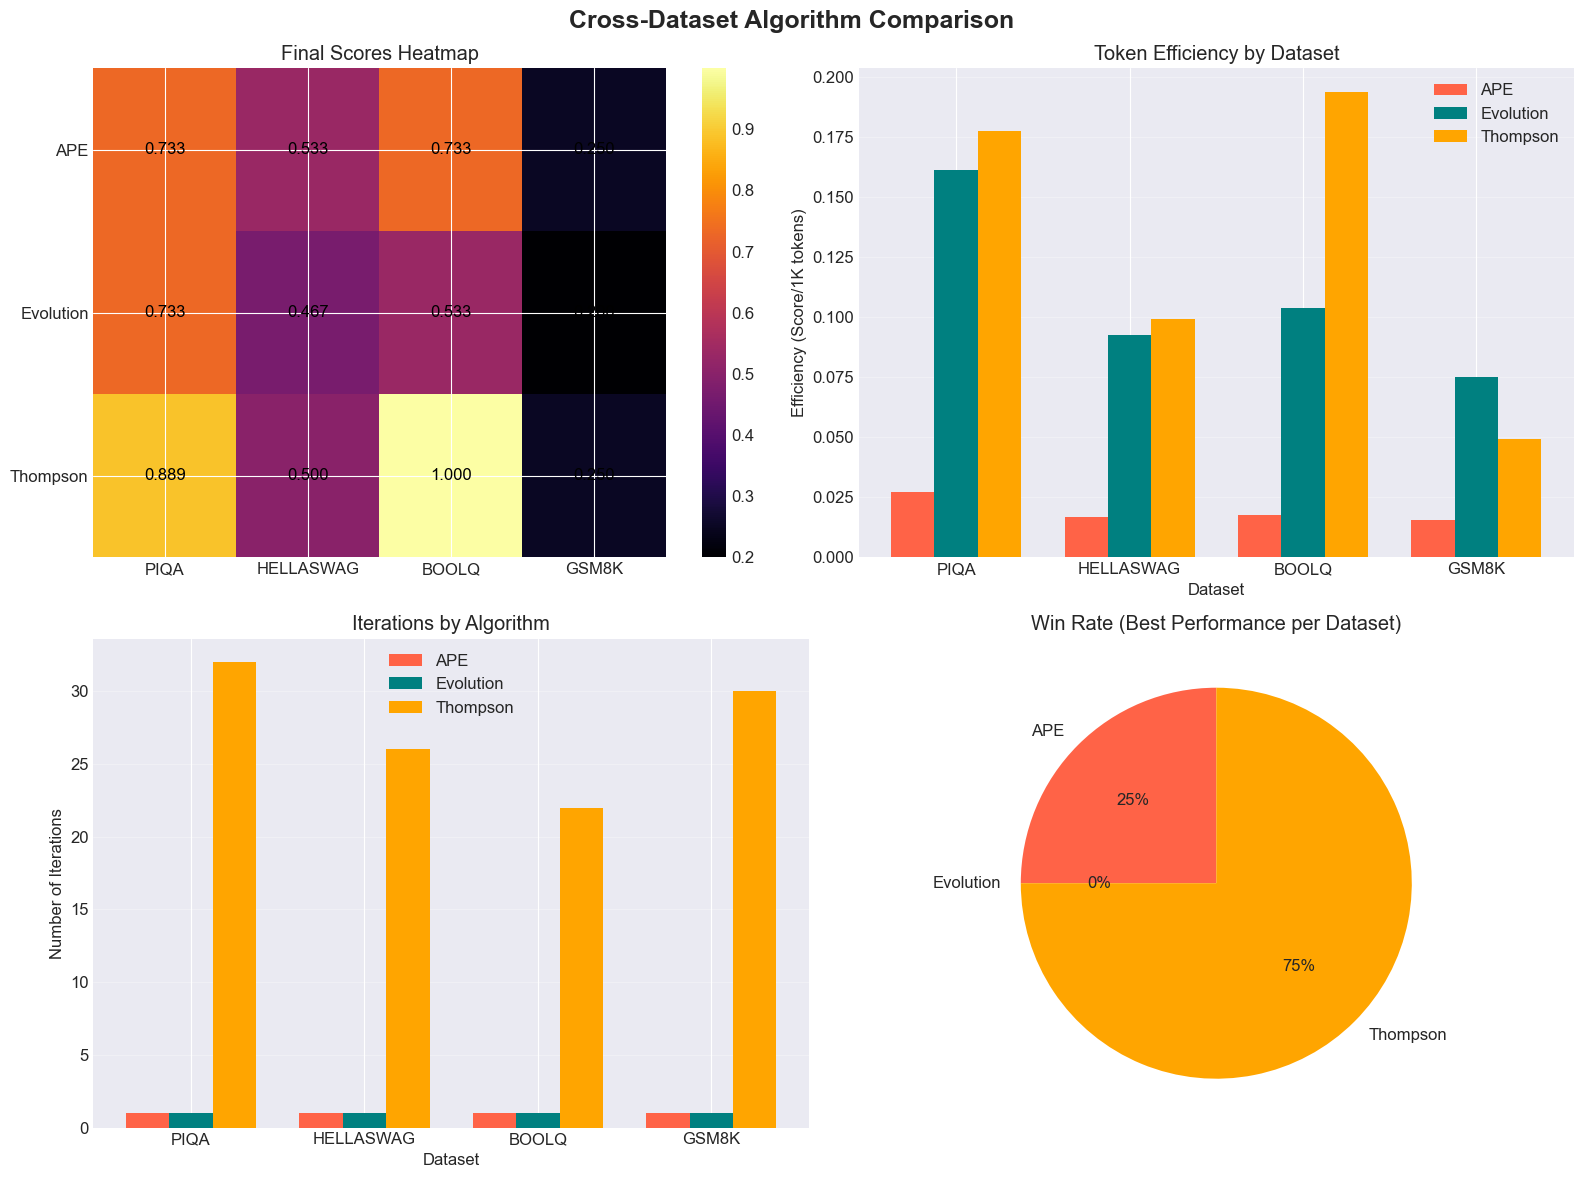

In [58]:
def comparison(results_dict):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cross-Dataset Algorithm Comparison',
                 fontsize=18, fontweight='bold')

    algorithms = ['ape', 'evo', 'ts']
    colors = {'ape': 'tomato', 'evo': 'teal', 'ts': 'orange'}
    labels = {'ape': 'APE', 'evo': 'Evolution', 'ts': 'Thompson'}

    dataset_names = list(results_dict.keys())

    # Final scores heatmap
    ax1 = axes[0, 0]
    score_matrix = []
    for alg in algorithms:
        alg_scores = []
        for dataset in dataset_names:
            data = results_dict[dataset]
            if alg in data and data[alg]['bestPrompts']:
                score = data[alg]['bestPrompts'][-1]['score']
            else:
                score = 0
            alg_scores.append(score)
        score_matrix.append(alg_scores)

    im = ax1.imshow(score_matrix, cmap='inferno', aspect='auto')
    ax1.set_xticks(range(len(dataset_names)))
    ax1.set_xticklabels([d.upper() for d in dataset_names])
    ax1.set_yticks(range(len(algorithms)))
    ax1.set_yticklabels([labels[alg] for alg in algorithms])
    ax1.set_title('Final Scores Heatmap')

    # Add annotations
    for i, alg in enumerate(algorithms):
        for j, dataset in enumerate(dataset_names):
            text = ax1.text(j, i, f'{score_matrix[i][j]:.3f}',
                          ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax1)

    # Token efficiency comparison
    ax2 = axes[0, 1]
    x = np.arange(len(dataset_names))
    width = 0.25

    for i, alg in enumerate(algorithms):
        efficiencies = []
        for dataset in dataset_names:
            data = results_dict[dataset]
            if alg in data and data[alg]['bestPrompts']:
                bp = data[alg]['bestPrompts'][-1]
                eff = calculate_efficiency(bp['tokens'], bp['score'])
            else:
                eff = 0
            efficiencies.append(eff)

        ax2.bar(x + i*width, efficiencies, width,
               label=labels[alg], color=colors[alg])

    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Efficiency (Score/1K tokens)')
    ax2.set_title('Token Efficiency by Dataset')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels([d.upper() for d in dataset_names])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # Iterations/rounds comparison
    ax3 = axes[1, 0]
    for i, alg in enumerate(algorithms):
        iterations = []
        for dataset in dataset_names:
            data = results_dict[dataset]
            if alg in data and data[alg]['bestPrompts']:
                iters = len(data[alg]['bestPrompts'])
            else:
                iters = 0
            iterations.append(iters)

        ax3.bar(x + i*width, iterations, width,
               label=labels[alg], color=colors[alg])

    ax3.set_xlabel('Dataset')
    ax3.set_ylabel('Number of Iterations')
    ax3.set_title('Iterations by Algorithm')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels([d.upper() for d in dataset_names])
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # Win rate (best algorithm per dataset)
    ax4 = axes[1, 1]
    wins = {alg: 0 for alg in algorithms}

    for dataset in dataset_names:
        data = results_dict[dataset]
        best_alg = None
        best_score = -1

        for alg in algorithms:
            if alg in data and data[alg]['bestPrompts']:
                score = data[alg]['bestPrompts'][-1]['score']
                if score > best_score:
                    best_score = score
                    best_alg = alg

        if best_alg:
            wins[best_alg] += 1

    ax4.pie([wins[alg] for alg in algorithms],
           labels=[labels[alg] for alg in algorithms],
           colors=[colors[alg] for alg in algorithms],
           autopct='%1.0f%%',
           startangle=90)
    ax4.set_title('Win Rate (Best Performance per Dataset)')

    plt.tight_layout()
    plt.savefig('plots_cross_dataset.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

if results:
    comparison(results)

## Summary

In [59]:
def summary(results_dict):
    rows = []

    for dataset_name, data in results_dict.items():
        for alg in ['ape', 'evo', 'ts']:
            if alg not in data or not data[alg]['bestPrompts']:
                continue

            bp = data[alg]['bestPrompts'][-1]

            rows.append({
                'Dataset': dataset_name.upper(),
                'Algorithm': {'ape': 'APE', 'evo': 'Evolution', 'ts': 'Thompson'}[alg],
                'Final Score': bp['score'],
                'Tokens Used': bp['tokens'],
                'Iterations': len(data[alg]['bestPrompts']),
                'Efficiency': calculate_efficiency(bp['tokens'], bp['score'])
            })

    df = pd.DataFrame(rows)

    pd.options.display.float_format = '{:.3f}'.format

    print(df.to_string(index=False))

    # Save to CSV
    df.to_csv('summary_statistics.csv', index=False)
    return df

summary_df = summary(results)

  Dataset Algorithm  Final Score  Tokens Used  Iterations  Efficiency
     PIQA       APE        0.733        27192           1       0.027
     PIQA Evolution        0.733         4543           1       0.161
     PIQA  Thompson        0.889         5005          32       0.178
HELLASWAG       APE        0.533        31990           1       0.017
HELLASWAG Evolution        0.467         5049           1       0.092
HELLASWAG  Thompson        0.500         5033          26       0.099
    BOOLQ       APE        0.733        42150           1       0.017
    BOOLQ Evolution        0.533         5142           1       0.104
    BOOLQ  Thompson        1.000         5155          22       0.194
    GSM8K       APE        0.250        16339           1       0.015
    GSM8K Evolution        0.200         2658           1       0.075
    GSM8K  Thompson        0.250         5060          30       0.049


In [60]:
def best_prompts(results_dict):
    print("BEST PROMPTS BY ALGO AND DATASET")

    for dataset_name, data in results_dict.items():
        print(f"Dataset: {dataset_name.upper()}")

        for alg in ['ape', 'evo', 'ts']:
            alg_name = {'ape': 'APE', 'evo': 'Evolution', 'ts': 'Thompson'}[alg]

            if alg in data and 'best' in data[alg]:
                best = data[alg]['best']
                score = data[alg]['bestPrompts'][-1]['score'] if data[alg]['bestPrompts'] else 0

                print(f"\n{alg_name} (Score: {score:.3f}):")
                print(f"  {best['instruction'][:150]}")
                print()

display_best_prompts(results)

BEST PROMPTS BY ALGORITHM AND DATASET
Dataset: PIQA

APE (Score: 0.733):
  You are a classifier for physical commonsense reasoning. Analyze both options carefully and choose the more practical solution. Return ONLY valid JSON


Evolution (Score: 0.733):
  You are a classifier for physical commonsense reasoning. Analyze both options carefully and choose the more practical solution. Return ONLY valid JSON


Thompson (Score: 0.889):
  You are a classifier for physical commonsense reasoning. Analyze both options carefully and choose the more practical solution. Return ONLY valid JSON

Dataset: HELLASWAG

APE (Score: 0.533):
  {"instruction": "Classify the given context as A, B, C or D based on common sense reasoning."}


Evolution (Score: 0.467):
  You are a commonsense reasoning classifier. Read the context and determine which ending makes most sense. Return ONLY valid JSON: {"label": "A|B|C|D"}


Thompson (Score: 0.500):
  {"instruction":"Classify the given context as A, B, C, or D based

## Learning Curves

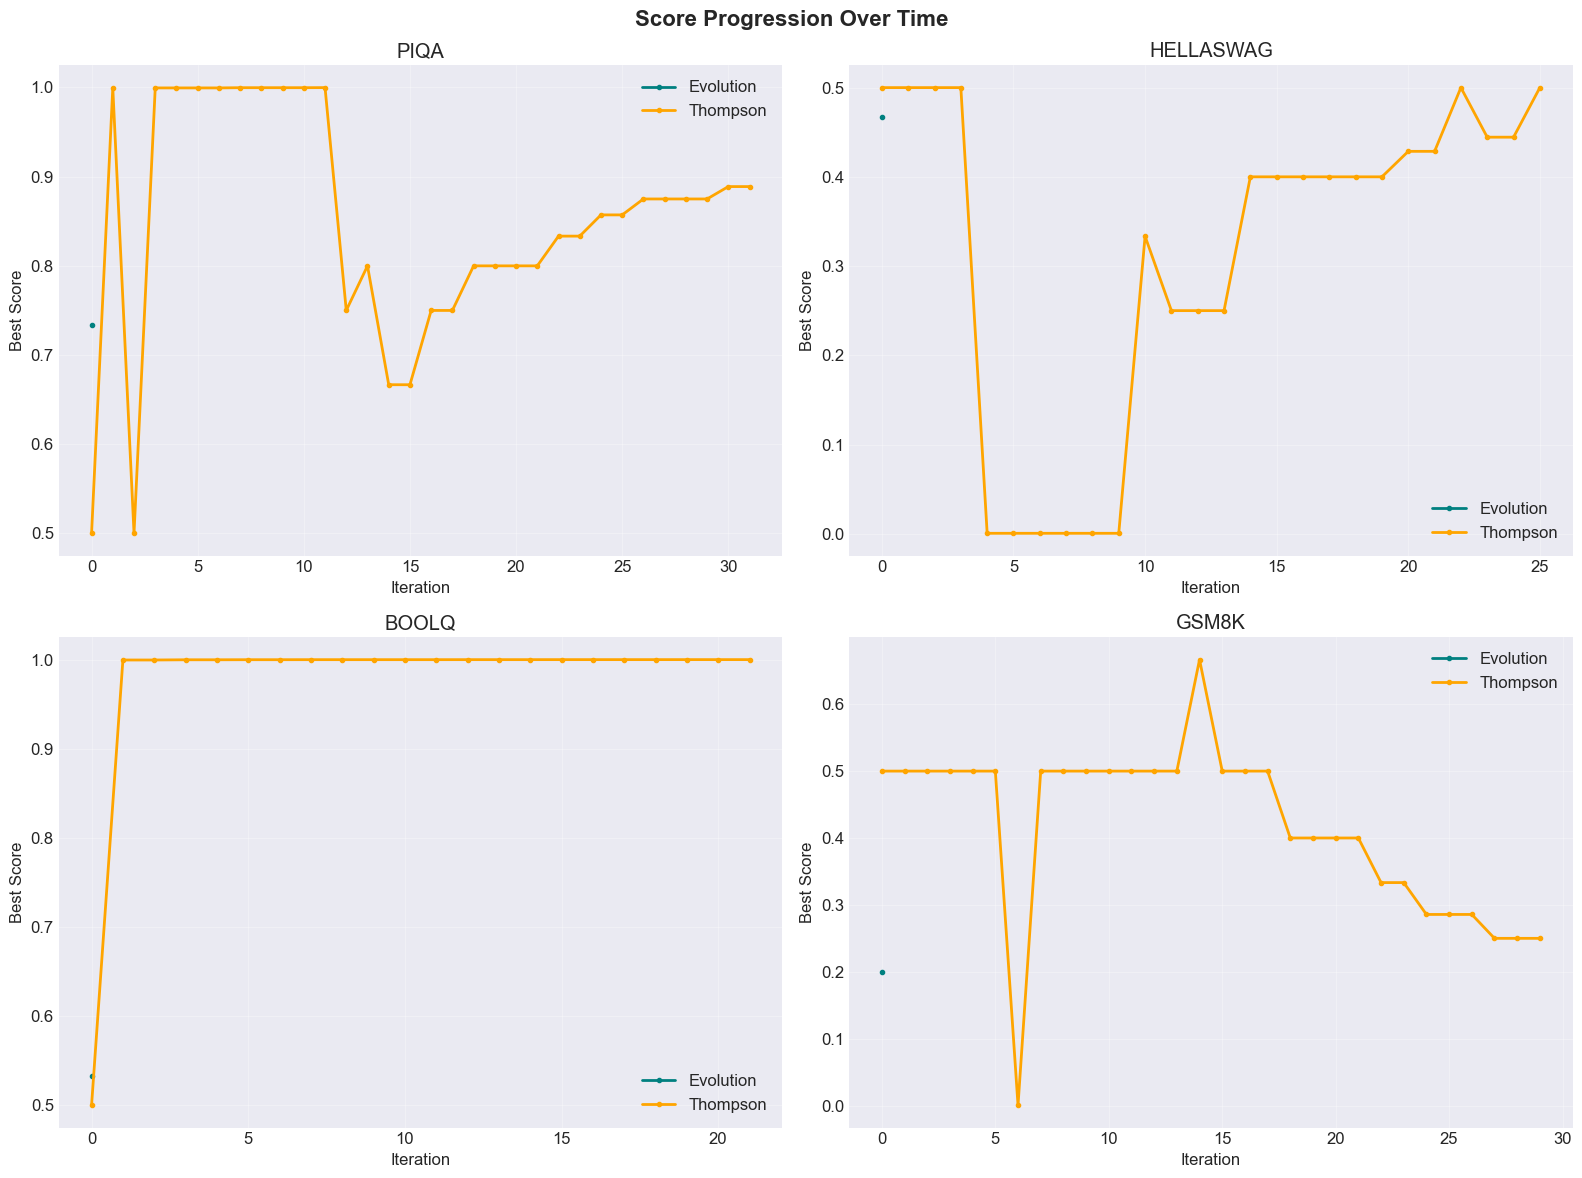

In [61]:
def plot_learning_curves(results_dict):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Score Progression Over Time',
                 fontsize=16, fontweight='bold')

    datasets = list(results_dict.keys())
    colors = {'evo': 'teal', 'ts': 'orange'}

    for idx, dataset in enumerate(datasets[:4]):
        ax = axes[idx // 2, idx % 2]
        data = results_dict[dataset]

        for alg in ['evo', 'ts']:
            if alg in data and data[alg]['bestPrompts']:
                iterations = range(len(data[alg]['bestPrompts']))
                scores = [bp['score'] for bp in data[alg]['bestPrompts']]

                label = 'Evolution' if alg == 'evo' else 'Thompson'
                ax.plot(iterations, scores,
                       marker='o', label=label,
                       color=colors[alg], linewidth=2, markersize=3)

        ax.set_xlabel('Iteration')
        ax.set_ylabel('Best Score')
        ax.set_title(f'{dataset.upper()}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_curves(results)

## Statistical Analysis

In [62]:
def analysis(summary_df):
    # Group by algorithm
    grouped = summary_df.groupby('Algorithm')

    print("\nMean Performance by Algorithm:")
    print(grouped[['Final Score', 'Tokens Used', 'Efficiency']].mean())

    print("\nStandard Deviation:")
    print(grouped[['Final Score', 'Tokens Used', 'Efficiency']].std())

    print("\nMedian Performance:")
    print(grouped[['Final Score', 'Tokens Used', 'Efficiency']].median())

    print("\nBest Algorithm by Metric:")
    print(f"  Highest Average Score: {summary_df.groupby('Algorithm')['Final Score'].mean().idxmax()}")
    print(f"  Lowest Token Usage: {summary_df.groupby('Algorithm')['Tokens Used'].mean().idxmin()}")
    print(f"  Highest Efficiency: {summary_df.groupby('Algorithm')['Efficiency'].mean().idxmax()}")

analysis(summary_df)


Mean Performance by Algorithm:
           Final Score  Tokens Used  Efficiency
Algorithm                                      
APE              0.562    29417.750       0.019
Evolution        0.483     4348.000       0.108
Thompson         0.660     5063.250       0.130

Standard Deviation:
           Final Score  Tokens Used  Efficiency
Algorithm                                      
APE              0.229    10719.675       0.005
Evolution        0.220     1157.002       0.037
Thompson         0.347       65.158       0.068

Median Performance:
           Final Score  Tokens Used  Efficiency
Algorithm                                      
APE              0.633    29591.000       0.017
Evolution        0.500     4796.000       0.098
Thompson         0.694     5046.500       0.138

Best Algorithm by Metric:
  Highest Average Score: Thompson
  Lowest Token Usage: Evolution
  Highest Efficiency: Thompson


## Reflection
### What can you conclude about the trade-offs between methods?
APE while being useful to generate a variety of prompts very quickly is not a very effective optimizer and it ends up being very costly as can be seen by the graphs for not much in terms of performance (in which it was the worst).

Evolutionary had the overall lowest token usage in my case though it's performance was equally not very good, I would assume this was due to the lack of enough different operators to actually effectively search through the search space. I also had less overall iterations with the Evolutionary algorithm as opposed to with Thompson Sampling.

Thompson Sampling had the best overall efficency (token usage per performance) and won 3/4 task with the 1st (PiQA) effictively tieing between all of them.

In regards to HellaSwag, I'm glad I ended up choosing 4 total datasets as by looking I could see the GMS8K was actually the overall hardest and probably requires better overal prompt structuring, BoolQ was too easy for gpt-4o-mini, and PiQA also seems to need a different overall prompting strategy seeing as all prompts did as good as random on it.
With HellaSwag however, Thompson sampling clearly outperforms on both performance and cost as compared to all others.
### Which method would you choose to move forward with?
I would move forward with Thompson Sampling as even though this evaluation was only on 8 tasks per dataset, it still generally out performed the 2 other methods while still being mindful of the cost on most datasets, I would be curious to see what needs to be  changed to better perform on PiQA and GMS8K however.
### Finally, how would you improve the algorithm(s) or develop your own algorithm to improve performance at a reasonable cost, if given the opportunity?
For the evolutionary approach, I believe by having a larger variety of mutators could help along with different setups of tournaments I think by only having a few and not optimising for them (ie: PromptBreeder meta prompt for the mutators) really constrained the performance and it probably would have performed much better. But as I was also having issues in regards to parsing with the smaller models I also kept my mutators limited.
For thompson sampling perhaps allowing it to take on an evolutionary approach by pruning N certain losers and adding N mutations of the top K winners to the candidate pool could be an interesting way of trying to search even more of the prompt space.